In [17]:
# 学習済みモデルとtalkenizerのimport
from transformers import BertForSequenceClassification, BertTokenizer
# データセットの作成
from datasets import load_dataset

# finetuning
import peft

# 訓練時のハイパーパラメータと学習の設定
from transformers import Trainer, TrainingArguments

# 評価用の関数の設定
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# 混同行列の作成
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# モデルの保存
import torch

In [15]:
import os

In [3]:
# 訓練済みモデルの読み込み
base_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# モデルをcudaに渡す
base_model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [18]:
# ファインチューニングの設定
peft_config = peft.LoraConfig(
    # タスクのタイプ
    task_type=peft.TaskType.SEQ_CLS,
    # 差分行列のランク
    r=100,
    lora_alpha=32,
    lora_dropout=0.1,
    # 推論に使う場合はinference_modeはTrue, 学習の時はFalse
    inference_mode=False,
    # 再学習の使う層
    target_modules="all-linear"
)

In [19]:
# peftをモデルに適用
sc_model = peft.get_peft_model(model=base_model, peft_config=peft_config)
# モデルをcudaに渡す
sc_model.cuda()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): L

In [20]:
# 学習するparamsの数
sc_model.print_trainable_parameters()

trainable params: 16,821,807 || all params: 126,383,454 || trainable%: 13.310133935728643


In [5]:
# tokenizerの読み込み
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [6]:
# csvファイルをデータセットに変換
train_data = load_dataset("csv", data_files="train_data.csv", column_names=["text", "label"], split="train")
valid_data = load_dataset("csv", data_files="valid_data.csv", column_names=["text", "label"], split="train")
test_data = load_dataset("csv", data_files="test_data.csv", column_names=["text", "label"], split="train")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
# labelをstringからclasslabelに変更
train_data = train_data.class_encode_column("label")
valid_data = valid_data.class_encode_column("label")
test_data = test_data.class_encode_column("label")

Casting to class labels:   0%|          | 0/8208 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1026 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1027 [00:00<?, ? examples/s]

In [9]:
# トークン化の関数
def tokenize(batch):
    # データセットのテキスト列を取得
    texts = batch["text"]
    if isinstance(texts, str):
        # テキストが単一の文字列の場合、tokenizerに直接渡す
        return tokenizer(texts, padding=True, truncation=True, max_length=128)
    elif isinstance(texts, (list, tuple)):
        # テキストがリストまたはタプルの場合、各要素を文字列に変換してtokenizerに渡す
        return tokenizer([str(text) for text in texts], padding=True, truncation=True, max_length=128)
    else:
        # 不正な入力形式の場合はエラーを発生させる
        raise ValueError("Invalid input format. Should be a string, a list/tuple of strings.")

In [10]:
# トークン化の関数を適用
train_data = train_data.map(tokenize, batched=True, batch_size=len(train_data))
valid_data = valid_data.map(tokenize, batched=True, batch_size=len(valid_data))
test_data = test_data.map(tokenize, batched=True, batch_size=len(test_data))

Map:   0%|          | 0/8208 [00:00<?, ? examples/s]

Map:   0%|          | 0/1026 [00:00<?, ? examples/s]

Map:   0%|          | 0/1027 [00:00<?, ? examples/s]

In [12]:
# pytorchに入力できるようにformatを変更
train_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
valid_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [14]:
# 評価用の関数の設定
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(result):
    labels = result.label_ids
    preds = result.predictions.argmax(-1)
    # accuracy_scoreの算出
    acc = accuracy_score(labels, preds)
    # f1_scoreの算出
    f1 = f1_score(labels, preds, average="weighted")
    return {
        "accuracy score": acc,
        "f1 score": f1
    }

In [23]:
# ハイパーパラメータの設定
training_args = TrainingArguments(
    output_dir="outputs/results/",
    evaluation_strategy="epoch",
    num_train_epochs=5,
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="outputs/logs/"
)

In [24]:
# 学習の設定
trainer = Trainer(
    model=sc_model,
    args = training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=valid_data,
    tokenizer=tokenizer
)

In [25]:
# 学習
trainer.train()

  0%|          | 0/5130 [00:00<?, ?it/s]

{'loss': 0.5737, 'grad_norm': 6.920473575592041, 'learning_rate': 0.0001, 'epoch': 0.49}
{'loss': 0.3175, 'grad_norm': 2.575648069381714, 'learning_rate': 8.920086393088553e-05, 'epoch': 0.97}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.2794044017791748, 'eval_accuracy score': 0.8918128654970761, 'eval_f1 score': 0.8724344538486769, 'eval_runtime': 4.8098, 'eval_samples_per_second': 213.313, 'eval_steps_per_second': 6.861, 'epoch': 1.0}
{'loss': 0.2889, 'grad_norm': 7.08595085144043, 'learning_rate': 7.840172786177106e-05, 'epoch': 1.46}
{'loss': 0.2708, 'grad_norm': 1.5977147817611694, 'learning_rate': 6.76025917926566e-05, 'epoch': 1.95}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.2525154650211334, 'eval_accuracy score': 0.9035087719298246, 'eval_f1 score': 0.8932232637695658, 'eval_runtime': 4.7707, 'eval_samples_per_second': 215.065, 'eval_steps_per_second': 6.917, 'epoch': 2.0}
{'loss': 0.2183, 'grad_norm': 1.3184304237365723, 'learning_rate': 5.680345572354212e-05, 'epoch': 2.44}
{'loss': 0.2306, 'grad_norm': 3.043123960494995, 'learning_rate': 4.6004319654427645e-05, 'epoch': 2.92}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.24983087182044983, 'eval_accuracy score': 0.905458089668616, 'eval_f1 score': 0.902599849952957, 'eval_runtime': 4.819, 'eval_samples_per_second': 212.908, 'eval_steps_per_second': 6.848, 'epoch': 3.0}
{'loss': 0.192, 'grad_norm': 0.22403790056705475, 'learning_rate': 3.5205183585313177e-05, 'epoch': 3.41}
{'loss': 0.178, 'grad_norm': 0.05758766084909439, 'learning_rate': 2.4406047516198705e-05, 'epoch': 3.9}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.3116656243801117, 'eval_accuracy score': 0.9103313840155945, 'eval_f1 score': 0.906463191402903, 'eval_runtime': 4.7864, 'eval_samples_per_second': 214.356, 'eval_steps_per_second': 6.894, 'epoch': 4.0}
{'loss': 0.1598, 'grad_norm': 0.07058913260698318, 'learning_rate': 1.3606911447084234e-05, 'epoch': 4.39}
{'loss': 0.1402, 'grad_norm': 1.1059907674789429, 'learning_rate': 2.8077753779697625e-06, 'epoch': 4.87}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.3381844460964203, 'eval_accuracy score': 0.9005847953216374, 'eval_f1 score': 0.8990896469111875, 'eval_runtime': 4.7798, 'eval_samples_per_second': 214.653, 'eval_steps_per_second': 6.904, 'epoch': 5.0}
{'train_runtime': 513.5134, 'train_samples_per_second': 79.92, 'train_steps_per_second': 9.99, 'train_loss': 0.2541890518010011, 'epoch': 5.0}


TrainOutput(global_step=5130, training_loss=0.2541890518010011, metrics={'train_runtime': 513.5134, 'train_samples_per_second': 79.92, 'train_steps_per_second': 9.99, 'train_loss': 0.2541890518010011, 'epoch': 5.0})

In [26]:
# モデルの評価
trainer.evaluate()

  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.3381844460964203,
 'eval_accuracy score': 0.9005847953216374,
 'eval_f1 score': 0.8990896469111875,
 'eval_runtime': 4.9776,
 'eval_samples_per_second': 206.123,
 'eval_steps_per_second': 6.63,
 'epoch': 5.0}

In [27]:
# テストデータで推論
pred_output = trainer.predict(test_data)
pred_output

  0%|          | 0/33 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[-4.5718126 , -1.4286088 ,  4.452692  ],
       [-2.941979  ,  1.4500481 ,  0.80569756],
       [-3.0486023 , -0.24174397,  2.1769414 ],
       ...,
       [-4.740777  , -1.3240819 ,  4.3530397 ],
       [-5.1214337 , -1.8542163 ,  5.44562   ],
       [-4.806441  , -2.080782  ,  5.2765517 ]], dtype=float32), label_ids=array([2, 2, 2, ..., 2, 2, 2], dtype=int64), metrics={'test_loss': 0.37595558166503906, 'test_accuracy score': 0.9065238558909445, 'test_f1 score': 0.9034239540638089, 'test_runtime': 5.0817, 'test_samples_per_second': 202.099, 'test_steps_per_second': 6.494})

## 混同行列

In [28]:
# pred_outputの中から最も高い確率のものを求めてそれをy_predとする
import numpy as np
y_pred = np.argmax(pred_output.predictions, axis=1)
y_pred

array([2, 1, 2, ..., 2, 2, 2], dtype=int64)

In [29]:
# 正解の用意
y_test = np.array(test_data["label"])
# label_nameの取得
label_name = test_data.features["label"].names

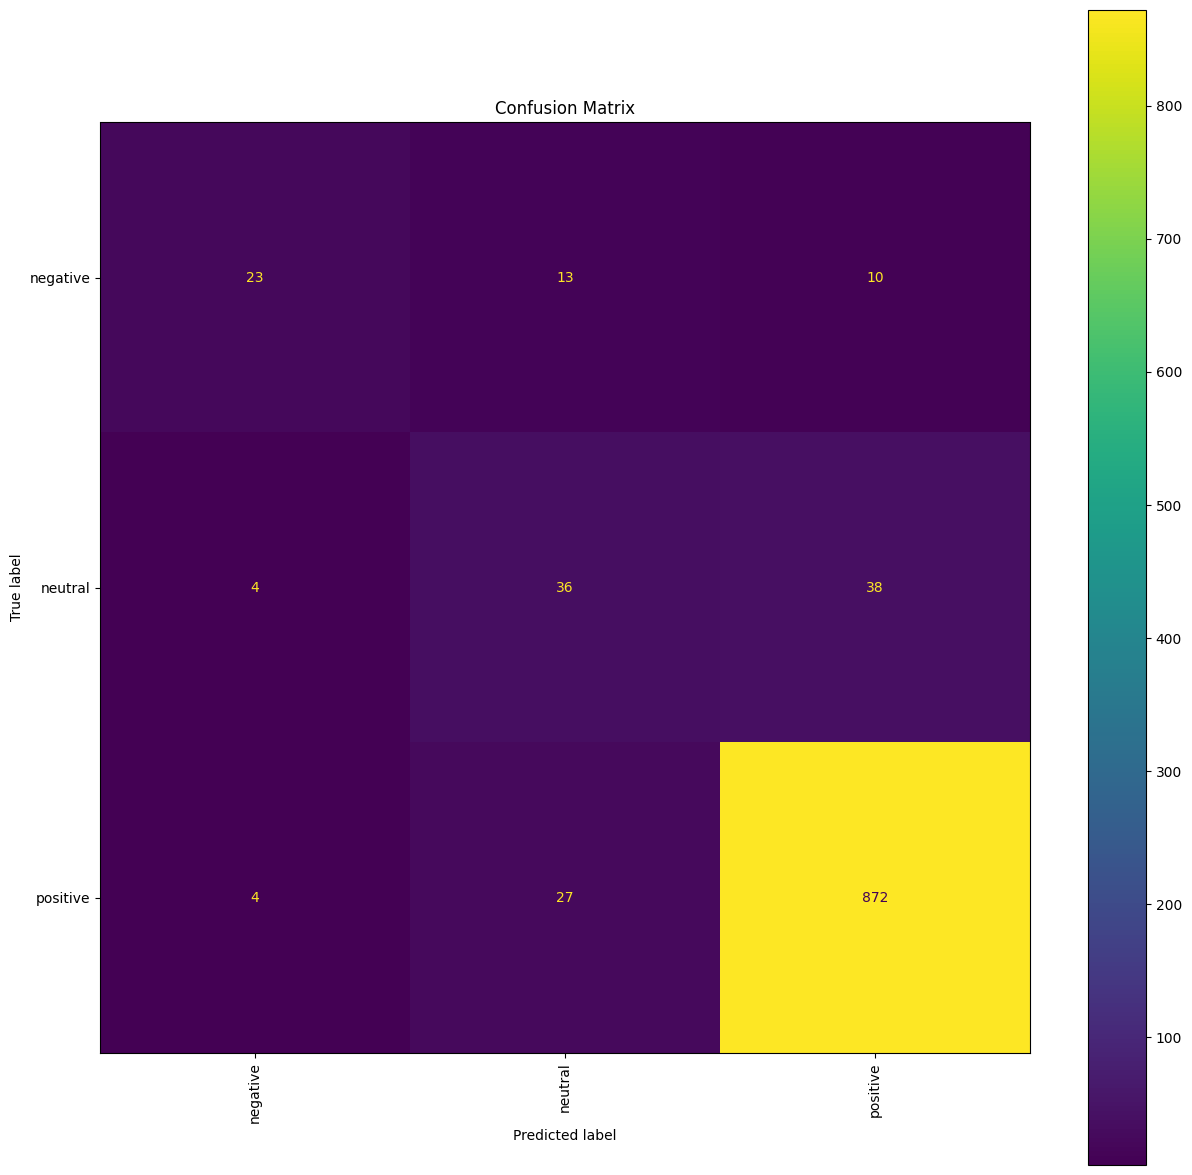

In [30]:
# 混同行列
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# 混同行列の可視化
fig, ax = plt.subplots(figsize=(15, 15))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
display.plot(ax=ax)
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.show()

## モデルの保存

In [31]:
# 保存先
model_path = "model_finetuned/"

# モデルの保存
sc_model.save_pretrained(model_path)
# tokenizerの保存
tokenizer.save_pretrained(model_path)

('model_finetuned/tokenizer_config.json',
 'model_finetuned/special_tokens_map.json',
 'model_finetuned/vocab.txt',
 'model_finetuned/added_tokens.json')

In [32]:
# torchで保存
torch.save(sc_model.state_dict(), "model_finetuned.ckpt")

In [34]:
# tensorboardによるlogの可視化
from torch.utils import tensorboard
%load_ext tensorboard
%tensorboard --logdir ./output/logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
